In [1]:
from scipy.io import loadmat, savemat
from scipy.linalg import orth
import numpy as np
import faiss
from scipy.spatial.distance import cdist
import pandas as pd

from tqdm import tqdm
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import gc
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'lib')))

from randn2 import randn2 
import peer_functions as peer

import math
from tqdm import tqdm
os.environ['OPENBLAS_NUM_THREADS'] = '1'

from datasets import ExperimentRunner


c:\Users\21361535\AppData\Local\anaconda3\envs\lava3\lib\site-packages\lava\utils\profiler.py:16: UserWarning: Loihi2HWProfiler could not be imported. Currently no profiler is available.
  warnings.warn("Loihi2HWProfiler could not be imported. "


In [2]:
def calculate_evaluation_metrics(similarity_matrix, ground_truth):
    """
    Calculate evaluation metrics for place recognition results
    
    Args:
        similarity_matrix: Matrix of similarity scores between queries and database
        ground_truth: Ground truth data containing GThard and GTsoft
        
    Returns:
        dict: Dictionary containing recalls, precision, recall curves and AUC
    """
    # Get candidate selections
    ids_pos = peer.directCandSel(similarity_matrix)
    
    # Calculate recall values
    recalls = peer.getRecallAtKVector(ids_pos, ground_truth["GT"])
    
    # Calculate precision-recall curves and AUC
    [R, P] = peer.createPR(-similarity_matrix, 
                          ground_truth['GT']["GThard"][0][0], 
                          ground_truth['GT']["GTsoft"][0][0])
    auc = np.trapz(P, R)
    
    return {
        'recalls': recalls,
        'precision': P,
        'recall': R,
        'auc': auc
    }



In [14]:
D1    = loadmat("../datasets/descriptors/GardensPointWalking/day_right/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
D2    = loadmat("../datasets/descriptors/GardensPointWalking/day_left/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']


g_truth = loadmat("../datasets/ground_truth/GardensPointWalking/day_right--day_left/gt.mat")

# D1    = loadmat("../datasets/descriptors/CMU/20110421/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
# D2    = loadmat("../datasets/descriptors/CMU/20100901/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']

# g_truth = loadmat("../datasets/ground_truth/CMU/20110421--20100901/gt.mat")


# D1    = loadmat("../datasets/descriptors/Nordland1000/spring/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
# D2    = loadmat("../datasets/descriptors/Nordland1000/winter/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']

# g_truth = loadmat("../datasets/ground_truth/Nordland1000/spring--winter/gt.mat")


In [4]:
from dot_product import  LoihiDotProductSimulationPositive, LoihiDotProductSimulationPositive3Layer, LoihiDotProductSimulationPositiveDBScale


## SNN 2 Layer

In [6]:
constant = 1/math.sqrt(2)

dot = LoihiDotProductSimulationPositiveDBScale(D1, D2, constant, timesteps=16, dbScale=6*3)


In [7]:
# DD, qs, dbs = dot.run()

qs, dbs, monitors = dot.run(monitor=True)

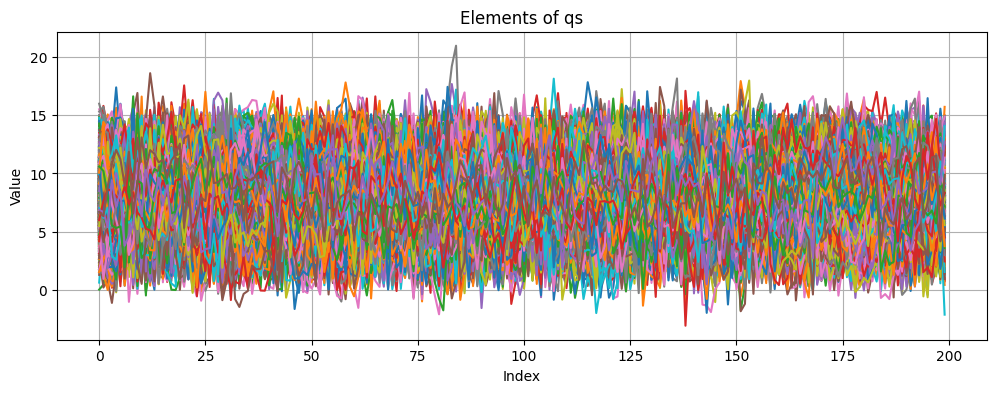

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(qs)
# plt.plot(qs[1], '-')
# plt.plot(qs[2], '-')
plt.title('Elements of qs')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

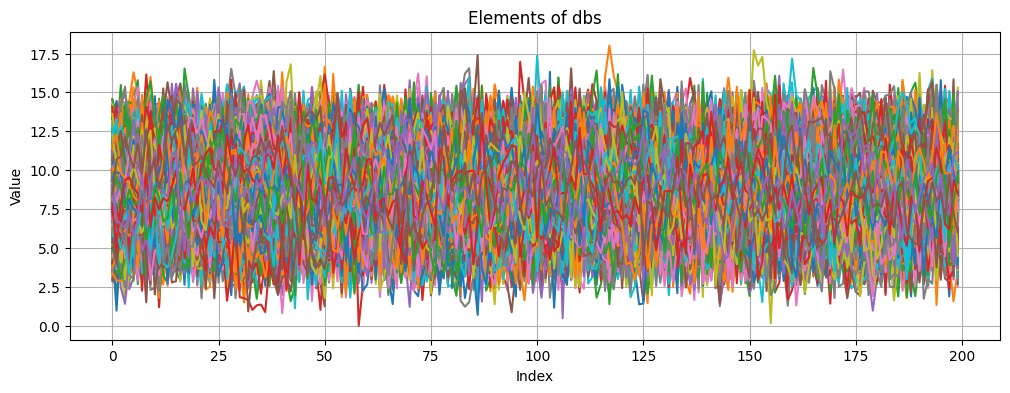

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(dbs)
# plt.plot(qs[1], '-')
# plt.plot(qs[2], '-')
plt.title('Elements of dbs')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

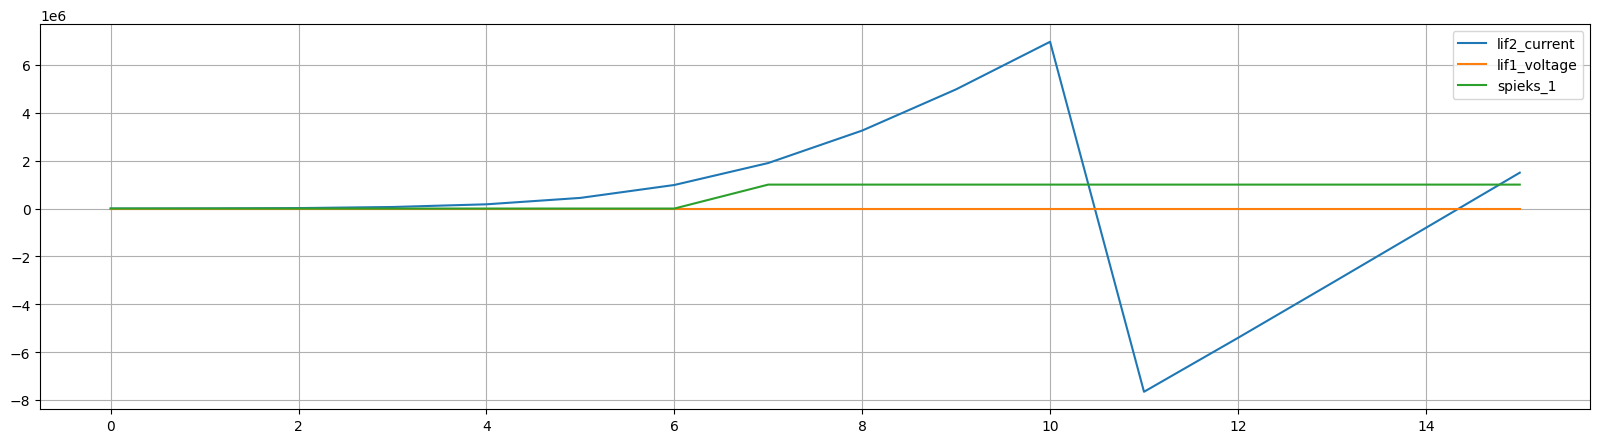

In [10]:
n_id = 150
plt.figure(figsize=(20, 5))
plt.plot(monitors['lif2_current'][:,n_id], label='lif2_current')
plt.plot(monitors['lif1_voltage'][:,n_id], label='lif1_voltage')
plt.plot(monitors['lif1_spikes'][:,n_id] * (10**6), label='spieks_1')
# plt.axhline(y=-(2**16 - 1)*2**6, color='r', linestyle='--', label='vth_lif_2')  # Changed to horizontal line
plt.grid(True)


plt.legend()
plt.show()


In [11]:
DD = dot.run(D1, D2, monitor=False)

100%|██████████| 200/200 [00:40<00:00,  4.89it/s]


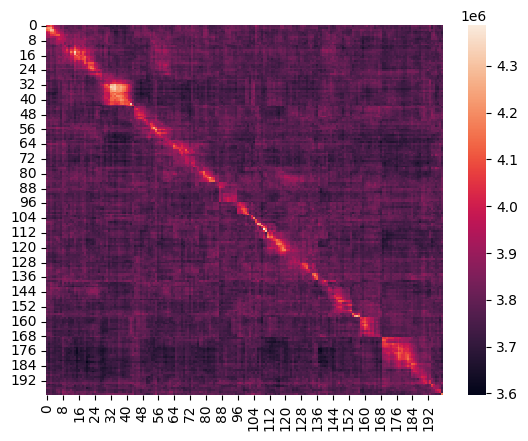

In [12]:
import seaborn as sns

ax = sns.heatmap(DD)
plt.show()

In [15]:

metrics = calculate_evaluation_metrics(-DD, g_truth)
print(f"AUC: {metrics['auc']}")


AUC: 0.8026922593264263


## Results

In [16]:
# Compute dot product between all pairs of vectors
dot_product_matrix = np.dot(qs, dbs.T)  # This will give a 200x200 matrix

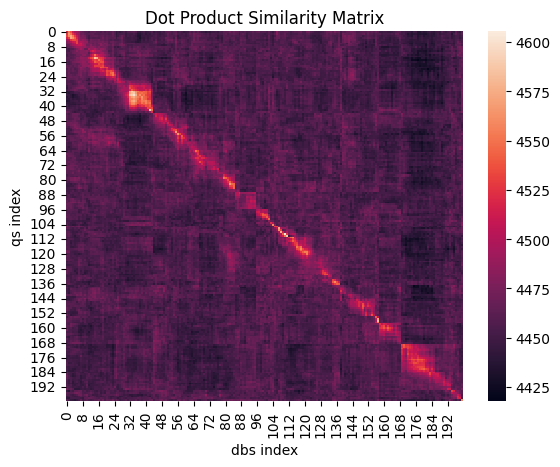

In [17]:
import seaborn as sns

ax = sns.heatmap(dot_product_matrix/2**6)
plt.title('Dot Product Similarity Matrix')
plt.xlabel('dbs index')
plt.ylabel('qs index')
plt.show()

In [18]:
metrics = calculate_evaluation_metrics(-dot_product_matrix, g_truth)
print(f"AUC: {metrics['auc']}")

AUC: 0.8180834138931743


In [16]:
0.406751268123599
0.406751268123599
0.406751268123599
0.41105831265952125 # Dense layer multiplied by 10 not timesteps (signs of overflow) -2,000
0.022280486025402297 # Dense layer multiplier changed to 1
0.4147533173640495 # Dense layer multiplied by 20 (signs of overflow) -10,000
# ============================================ Upto this, the constant is 0
0.005699984139190401 # Constant changed to 1/sqrt(2)
0.29100275201856207 # Constant changed to 0 while the vector transformation is done as per positive cpu experiment
0.4528012779410795
0.45785226214439223
0.4634606913087941

0.4634606913087941

In [17]:
hrd =   g_truth['GT']["GThard"][0][0]


In [18]:
sft =   g_truth['GT']["GTsoft"][0][0]

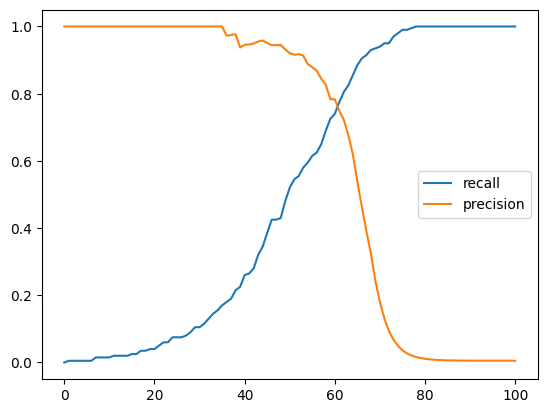

In [19]:
plt.plot(metrics['recall'], label='recall')
plt.plot(metrics['precision'], label='precision')
plt.legend()


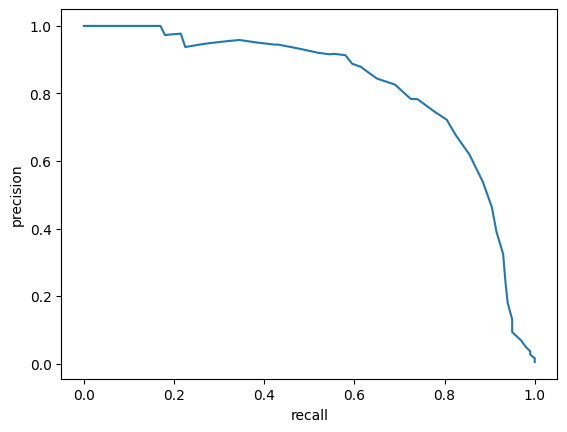

In [20]:

# plt.plot(metrics['precision'], metrics['recall'])
plt.plot(metrics['recall'], metrics['precision'])
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

